In [ ]:
""" 
Detailed analyses of line2 e4xperiments 
over last few days.
- Addressing a verity of questions related to genraelzation.

THIS IS GOOD CODE - lots of stuff.
NOTE: moving everything to analysis_modelexpt. This is OBSOLETE.

"""

In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/data1/code/python/drawmonkey


In [2]:
from tools.utils import * 
from tools.plots import *
from tools.analy import *
from tools.calc import *
from tools.analyplot import *
from tools.preprocess import *
from tools.dayanalysis import *
from analysis.line2 import *

from pythonlib.drawmodel.analysis import *
from pythonlib.tools.stroketools import *

NOTE: need to not overwrite strokes_all_task, because then the orders saved will stop being accurate. Modify


# ACROSS-DAY ANALYSIS (MULTI ANIMAL)

In [3]:
# Plot same task across days

# 1) Load data across days
from pythonlib.tools.datetools import getDateList

sdate = 200902
edate = 200907
datelist = getDateList(sdate, edate)

expt = "lines2"
for animal in ["Pancho", "Red"]:
    
    dattoget = []
    for d in datelist:
        dattoget.append([expt, animal, d])
        
    FD = loadMultData(dattoget)

    # saving dir
    SAVEDIR = f"{FD[0]['fd']['params']['figuredir_notebook']}/analysis_line2_090720/multday_{animal}_{sdate}_to_{edate}"
    import os
    os.makedirs(SAVEDIR, exist_ok=True)
    print(f"saving at {SAVEDIR}")

    # ==== Flatten all trials across days x animals
    # for each trial collect relevant information
    from analysis.line2 import PROBEDATfromFD
    PROBEDAT = PROBEDATfromFD(FD)
    

    
    # === Focus on a single task. Plot its trajectory and compare difefrent days
    # - 1) visualize candidate tasks
    # a) first, only consider fixed tasks
    print("--- list of fixed tasks:")
    T = sorted(set([P["unique_task_name"] for P in PROBEDAT if P["random_task"]==False]))
    [print(t) for t in T];

    # get all fixed tasks of a particular kind
    kindlist = set([P["kind"] for P in PROBEDAT if P["random_task"]==False])

    task_per_kind = {}
    for kind in kindlist:
        tasklist = set([P["unique_task_name"] for P in PROBEDAT if P["kind"]==kind])
        task_per_kind[kind]=sorted(tasklist)

    print("tasks per kind found")
    for k, v in task_per_kind.items():
        print("----")
        print(f"=={k}")
        [print(vv) for vv in v]




    ## PLOT - all trials, 2d grid sorted by date and task category

    # == get all task stages (catregories) that have data across dates
    max_strokenum = 2 # for single stroke plots

    # only keep data for fixed tasks.
    PROBEDATthis = [P for P in PROBEDAT if P["random_task"]==False]
    datelist = sorted(set([P["date"] for P in PROBEDATthis]))

    # all categories that have fixed tasks
    stagelist = set([P["task_stagecategory"] for P in PROBEDATthis if P["random_task"]==False])

    # # for each category, check that has data across days
    # if False:
    #     # not done - currently taking all stages
    #     for stage in stagelist:
    #         datelist = set([P["date"] for P in PROBEDATthis if P["task_stagecategory"] == stage])

    # for each stage, make a 2d grid plot (date x task)
    for stage in stagelist:
        tasklist = sorted(set([P["unique_task_name"] for P in PROBEDATthis if P["task_stagecategory"]==stage]))
        if len(tasklist)>50:
            assert False, "why so many tasks for this stage?"

        # -- Plot 2d grid, separated by days
        CAT1 = ["date", datelist]
        CAT2 = ["unique_task_name", tasklist]
        fdlist = None

        # == 1) All behavior trials, all strokes overlaid
        plotargs = {"zoom":True, "plotver":"order", "markersize":4, "alpha":0.25}
        # fdlist = [P["filedata"][0]() for P in PROBEDATthis]
        # fdlist = [FD[P["ii"]]["fd"] for P in PROBEDATthis]

        fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="beh", plotargs=plotargs);
        fig.savefig(f"{SAVEDIR}/alltrials_datebycategory_beh_{stage}.pdf")
        fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="task", plotargs=plotargs);
        fig.savefig(f"{SAVEDIR}/alltrials_datebycategory_task_{stage}.pdf")


        # == 2) Split by stroke number (one plot for each stroke)
        plotargs = {"zoom":True, "plotver":"order", "markersize":3, "alpha":0.2}
        strokenums_to_plot_alone=list(range(max_strokenum+1))
        overlay_stroke_mean=True

        fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="behtask", 
                              plotargs=plotargs, strokenums_to_plot_alone=strokenums_to_plot_alone, 
                             overlay_stroke_mean = overlay_stroke_mean);
        fig.savefig(f"{SAVEDIR}/alltrials_datebycategory_eachstroke_beh_{stage}.pdf")


        # == 3) All strokes (faint) and overlay average
        plotargs = {"zoom":True, "plotver":"order", "markersize":2, "alpha":0.15}

        overlay_stroke_mean=True
        fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="beh", 
                              plotargs=plotargs, overlay_stroke_mean=overlay_stroke_mean);
        fig.savefig(f"{SAVEDIR}/alltrials_datebycategory_strokemeans_{stage}.pdf")
        
    # ==== PLOT ALL TRIALS
    tasklist = set([P["unique_task_name"] for P in PROBEDATthis if P["random_task"]==False])
    NMAX = 20 # trials to plot, starting from 1st trial int he day
    for task in tasklist:

        PD = [P for P in PROBEDATthis if P["random_task"]==False and P["unique_task_name"]==task]

        for reverse in [False, True]:
            # -- task presentation num as column
            for P in PD:
                P["idx_today_uniquetask"] = None
            PD, countlist = probeDatIndexWithinDay(PD, task, reverse_order=reverse);

            # -- how many examples to plot?
            ntoplot = min((max(countlist), NMAX))

            # -- Plot 2d grid, separated by days
            CAT1 = ["date", datelist]
            CAT2 = ["idx_today_uniquetask", range(ntoplot)]
            fdlist = None

            # == 1) All behavior trials, all strokes overlaid
            plotargs = {"zoom":True, "plotver":"order", "markersize":8, "alpha":0.7}
            plot_task_last_col = True
            ver = "behtask"

            fig = plotTrial2dGrid(PD, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver=ver, 
                                  plotargs=plotargs, plot_task_last_col=plot_task_last_col);
            if reverse:
                fig.savefig(f"{SAVEDIR}/egtrials_datebyexample_revchronorder_{task}.pdf")
            else:
                fig.savefig(f"{SAVEDIR}/egtrials_datebyexample_chronorder_{task}.pdf")
        
    plt.close()

['lines2', 'Pancho', '200902']
did not find any glob match to /data2/animals/Pancho/200902/200902_*_lines2_Pancho_0.h5!!
- No h5 file for Pancho, 200902, lines2, 0 - returning None!
found one matching filename: ['/data2/animals/Pancho/200902/200902_151207_lines2_Pancho_1.h5']
found one matching filename: ['/data2/animals/Pancho/200902/200902_151207_lines2_Pancho_1.pkl']
-- loaded presaved data: /data2/animals/Pancho/200902/200902_151207_lines2_Pancho_1.pkl
appending fd for sess 1
found one matching filename: ['/data2/animals/Pancho/200902/200902_154332_lines2_Pancho_2.h5']
found one matching filename: ['/data2/animals/Pancho/200902/200902_154332_lines2_Pancho_2.pkl']
-- loaded presaved data: /data2/animals/Pancho/200902/200902_154332_lines2_Pancho_2.pkl
appending fd for sess 2
did not find any glob match to /data2/animals/Pancho/200902/200902_*_lines2_Pancho_3.h5!!
- No h5 file for Pancho, 200902, lines2, 3 - returning None!
did not find any glob match to /data2/animals/Pancho/200902/2

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/data1/code/python/drawmonkey/tools/preprocess.py", line 248, in loadSingleData
    filedata = pickle.load(f)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-2d3cff6def26>", line 17, in <module>
    FD = loadMultData(dattoget)
  File "/data1/code/python/drawmonkey/tools/preprocess.py", line 81, in loadMultData
    resave_overwrite=False)
  File "/data1/code/python/drawmonkey/tools/preprocess.py", line 248, in loadSingleData
    filedata = pickle.load(f)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/IPython/core/interacti

TypeError: can only concatenate str (not "list") to str

## 9/22/20 - what I now think as important plots


2) Analyze curvature as a measurement of bendiness



1) In general, use stroke model to assign probabilites for each strok for being of certain class (use strokModel)


In [4]:
from analysis.line2_strokmodelfits import *
def modelResultsGetter(PROBEDAT, model="spatial", fit_tstamp = "200922_093340_lines2"):
    """ given PROBEDAT, return a function that you can use to pull out model 
    results for a given trial/stroke
    - model and fit_tstamp index a particular run of model fitting.
    RETURNS:
    - resultGetter, a function that takes in specific details of expt (down to level
    of strokenum) and extracts, from processed dataframe, model fit results.
    NOTE: can fail silently, in that if dosent find something, will return a None.
    should modify so that is known what should or should not exist.
    """
    
    # 1) Load previously saved strok model fits.
#     model = "spatial"
#     fit_tstamp = "200922_093340_lines2"

    datlist = set([(P["animal"], P["session"], P["date"],  P["expt"]) for P in PROBEDAT])

    # for each combo, load and put in a dict, so that can align trials later.
    MODELDAT = []
    for dat in datlist:
        try:
            strokdat, DF, DF2, fd = \
                postProcess(dat[0], dat[1], dat[2], dat[3], fit_tstamp=fit_tstamp, model=model,ploton=False)

            print(f"** GOOD! Found for this dat: {dat}")
            MODELDAT.append({
                "animal":dat[0],
                "date":dat[2],
                "expt":dat[3],
                "session":dat[1],
                "DF":DF,
                "DF2":DF2
            })
        except FileNotFoundError as err:
            print(err)
            print('SKIPPING')
            continue

    
    def resultGetter(animal, date, expt, session, trial, strok_num):
        """function to extract model stats for a given trial/stroke, 
        given the MODELDAT listy of dicts
        - returns None if can't find for whatever reason
        By default, extracts the model1/model2 score for the trial, which is 
        one df row. could also choose to extract one row for each model."""

        for M in MODELDAT:
            if M["animal"]==animal and M["date"]==date and M["expt"]==expt and M["session"]==session:
                DF = M["DF"]
                DF2 = M["DF2"]

                if False:
                    DFthis = DF[(DF["trial"]==trial) & (DF["strok_num_0"]==strok_num)]
                else:
                    DFthis = DF2[(DF2["trial"]==trial) & (DF2["strok_num_0"]==strok_num)]

                if len(DFthis)==0:
                    return None
                else:
                    return DFthis
        if False:
            print("DID NOT FIND THIS DATA!")
        return None
    
#     extractDatForStroke(MODELDAT, "Pancho", "200907", "lines2", 1, 10, 1)
    return resultGetter

# resultGetter = modelResultsGetter(PROBEDAT, model="spatial", fit_tstamp = "200922_093340_lines2")

# resultGetter("Pancho", "200907", "lines2", 1, 10, 1)


# STROKE STATISTICS - ACROSS ANIMALS



# SINGLE ANIMAL


In [ ]:
from pythonlib.tools.datetools import getDateList

sdate = 200902
edate = 200907
datelist = getDateList(sdate, edate)

expt = "lines2"
animal = "Pancho"
    
dattoget = []
for d in datelist:
    dattoget.append([expt, animal, d])

FD = loadMultData(dattoget)

# saving dir
SAVEDIR = f"{FD[0]['fd']['params']['figuredir_notebook']}/analysis_line2_090720/multday_{animal}_{sdate}_to_{edate}"
import os
os.makedirs(SAVEDIR, exist_ok=True)
print(f"saving at {SAVEDIR}")

# ==== Flatten all trials across days x animals
# for each trial collect relevant information
from analysis.line2 import PROBEDATfromFD

PROBEDAT = PROBEDATfromFD(FD)

# CODE DEVElOPMENT

## AVERAGE STROKE

In [ ]:
if False:
        ## ===== given a list of strokes, take the average of those strokes
    # method: align all strokes by interpolation.
    strokeslist = [getTrialsStrokesByPeanuts(P["filedata"], P["trial"]) for P in PROBEDAT[:5]]

    # take average for x and y independently.
    strokenum = 0

    # pick out that desired stroke num
    slist = [s[strokenum] for s in strokeslist if len(s)>strokenum]

    # interpolate each strokes (using actual time)
    from pythonlib.tools.stroketools import strokesInterpolate
    Npts = 50
    slist_interp = strokesInterpolate(slist, Npts, uniform=False)


    # sanity check, plot
    plt.figure(figsize=(10,10))
    from pythonlib.drawmodel.strokePlots import plotDatStrokes

    ax = plt.subplot(211)
    plotDatStrokes(slist, ax=ax, plotver="order", each_stroke_separate=False)


    ax = plt.subplot(212)
    plotDatStrokes(slist_interp, ax=ax, plotver="order", each_stroke_separate=False)


    # stack the arrays and then take average
    slist_interp_stack = np.stack(slist_interp)
    slist_interp_stack.shape
    strok_mean = np.mean(slist_interp_stack, axis=0)

    # get std and sem
    strok_std = np.std(slist_interp_stack, axis=0)



    plotDatStrokes([strok_mean], ax=ax, plotver="randcolor", each_stroke_separate=True)




In [ ]:
## WAYS TO QUANTIFY VARIABILITY OF STROKES
# 1) covariance structure (plto as clouds on eac point)
# 2) same, but only onset and offset, which makes thingse asier
# 3) resampling
# 4) plot x and y separately?
# 5) align onto a 1d-axis, which is along the task (difficult to do... prob ignore)

# lthere are tasks that are fixed in one set of days but random in other./`

In [ ]:
## Not just motor habit - order often differs (both of stroke and of direction within stroke).

# but becomes more and more like motor habit as more practice:
# - correalted timecourses.


In [ ]:
# 1) clean strokes DONE
# 2) mean 1st, second, etc DONE
# 3) seaprate by stroke num DONE
# 4) plot 1st N trials each day DONE
# 5) plot N (matched)


## score behavior


# plot one specific task

In [ ]:
task_to_get = "C_1-protype"
task_to_get = "teepee_1-protype"

# Filter dat to only get this task
PROBEDATthis = [P for P in PROBEDAT if P["unique_task_name"]==task_to_get]
print(len(PROBEDATthis))
from pythonlib.tools.dicttools import printOverviewKeyValues
printOverviewKeyValues(PROBEDATthis)

# -- Plot over timecourse over days

In [ ]:
# -- Plot 2d grid, separated by days
CAT1 = ["date", []]
CAT2 = None
plotargs = {"zoom":True, "plotver":"strokes", "markersize":4, "alpha":0.25}
# fdlist = [P["filedata"][0]() for P in PROBEDATthis]
fdlist = None
# fdlist = [FD[P["ii"]]["fd"] for P in PROBEDATthis]

fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="beh", plotargs=plotargs);
# fig.savefig(f"{SAVEDIR}/psychometric_trials_beh_{settoget}.pdf")
fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="task", plotargs=plotargs);
# fig.savefig(f"{SAVEDIR}/psychometric_trials_task_{settoget}.pdf")

In [ ]:
# Learning - same task over time/days


In [ ]:
# Collect all cases where same task is done in different contexts:
# 1) Same animal, diff training
# 2) Diff animal, diff training
# 3) Diff animal, same training (might not be any of this)



In [ ]:
# During 2-stroke, stop after secind stroke?

# Trial end after lift > N seconds? Plot timing distryubitnos./

In [ ]:
# Can decode character?


In [ ]:
# Get more stereotyped with practice 
# seems clear from psychometric tasks

In [ ]:
# CHECK ANALYSES TO DO IN SPREADSHEET

## structure of variability

1. same task, different primitives
2. same task, same primitives, different order.
3. relates to psychometric functions - what stimulus features drive this variability?
4. reduction in variability over experiences.
5. motor-level variability, in timing and kinematics

[note: all of these maybe addressed by done-button verson, where seems to be more variability
- also, variability of number of strokes]

IMPoRTANT: if question is what drives structure of variablity, answer might be depends on prior knowledge. Goal of analyses is to see whether structure of variability influenced by this prior knowledge.

## motor analyses

1) motor-level invariance:
    same stroke different tasks
    same bigram strokes diff tasks
    
    the above, but same task different parses
    Goal:
        if so, then can do modeling of primitives?
        if so, then useful for neural recordings?
        

## EMAIL TO SELF - good outline


    A) First analysis just show that is copying task correctly.
    - shuffle across task categories. shuffle within task categories.
    - better or worse given different models?


    B) Second, look at compositional structure
    Different analyses to look at structure difference for
    compositionality v1 (strokes):

    1) Stroke statistics:
    - length, straightness, etc.
    - bag of strokes, across all tasks, showing that depend on training. compare to models (ground truth (two models) and spline fit).

    - [spline fit model] - THINK ABOUT THIS - not obvious if would work, since here is compositionality v1.

    - task by task, ask whether beahvior matches model. shuffle tasks.


## STROKE STATISTICS


### 1) Extract one datapoint for each stroke (flat across trials)

['lines2', 'Pancho', '200902']
did not find any glob match to /data2/animals/Pancho/200902/200902_*_lines2_Pancho_0.h5!!
- No h5 file for Pancho, 200902, lines2, 0 - returning None!
found one matching filename: ['/data2/animals/Pancho/200902/200902_151207_lines2_Pancho_1.h5']
found one matching filename: ['/data2/animals/Pancho/200902/200902_151207_lines2_Pancho_1.pkl']
-- loaded presaved data: /data2/animals/Pancho/200902/200902_151207_lines2_Pancho_1.pkl
appending fd for sess 1
found one matching filename: ['/data2/animals/Pancho/200902/200902_154332_lines2_Pancho_2.h5']
found one matching filename: ['/data2/animals/Pancho/200902/200902_154332_lines2_Pancho_2.pkl']
-- loaded presaved data: /data2/animals/Pancho/200902/200902_154332_lines2_Pancho_2.pkl
appending fd for sess 2
did not find any glob match to /data2/animals/Pancho/200902/200902_*_lines2_Pancho_3.h5!!
- No h5 file for Pancho, 200902, lines2, 3 - returning None!
did not find any glob match to /data2/animals/Pancho/200902/2

-- loaded presaved data: /data2/animals/Pancho/200907/200907_150018_lines2_Pancho_1.pkl
appending fd for sess 1
found one matching filename: ['/data2/animals/Pancho/200907/200907_152527_lines2_Pancho_2.h5']
found one matching filename: ['/data2/animals/Pancho/200907/200907_152527_lines2_Pancho_2.pkl']
-- loaded presaved data: /data2/animals/Pancho/200907/200907_152527_lines2_Pancho_2.pkl
appending fd for sess 2
did not find any glob match to /data2/animals/Pancho/200907/200907_*_lines2_Pancho_3.h5!!
- No h5 file for Pancho, 200907, lines2, 3 - returning None!
did not find any glob match to /data2/animals/Pancho/200907/200907_*_lines2_Pancho_4.h5!!
- No h5 file for Pancho, 200907, lines2, 4 - returning None!
did not find any glob match to /data2/animals/Pancho/200907/200907_*_lines2_Pancho_5.h5!!
- No h5 file for Pancho, 200907, lines2, 5 - returning None!
did not find any glob match to /data2/animals/Pancho/200907/200907_*_lines2_Pancho_6.h5!!
- No h5 file for Pancho, 200907, lines2, 6

/data1/code/python/pythonlib/pythonlib/drawmodel/features.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return [1-p/t for p,t in zip(displace,distance)]
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**

{'circularity': ['mean', 'median'], 'distance': ['mean', 'median'], 'Lstrokeindex': ['mean', 'median']}


/data1/code/python/pythonlib/pythonlib/drawmodel/features.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return [1-p/t for p,t in zip(displace,distance)]
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'circularity': ['mean', 'median'], 'distance': ['mean', 'median'], 'Lstrokeindex': ['mean', 'median']}


/data1/code/python/pythonlib/pythonlib/drawmodel/features.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return [1-p/t for p,t in zip(displace,distance)]
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/minico

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_

{'circularity': ['mean', 'median'], 'distance': ['mean', 'median'], 'Lstrokeindex': ['mean', 'median']}


/data1/code/python/pythonlib/pythonlib/drawmodel/features.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return [1-p/t for p,t in zip(displace,distance)]
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/minico

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/minico

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_

{'circularity': ['mean', 'median'], 'distance': ['mean', 'median'], 'Lstrokeindex': ['mean', 'median']}


/data1/code/python/pythonlib/pythonlib/drawmodel/features.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return [1-p/t for p,t in zip(displace,distance)]
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lucast

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_

{'circularity': ['mean', 'median'], 'distance': ['mean', 'median'], 'Lstrokeindex': ['mean', 'median']}


/data1/code/python/pythonlib/pythonlib/drawmodel/features.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return [1-p/t for p,t in zip(displace,distance)]
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/minico

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_

/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/lucast4/miniconda3/envs/drag/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lucast

{'circularity': ['mean', 'median'], 'distance': ['mean', 'median'], 'Lstrokeindex': ['mean', 'median']}


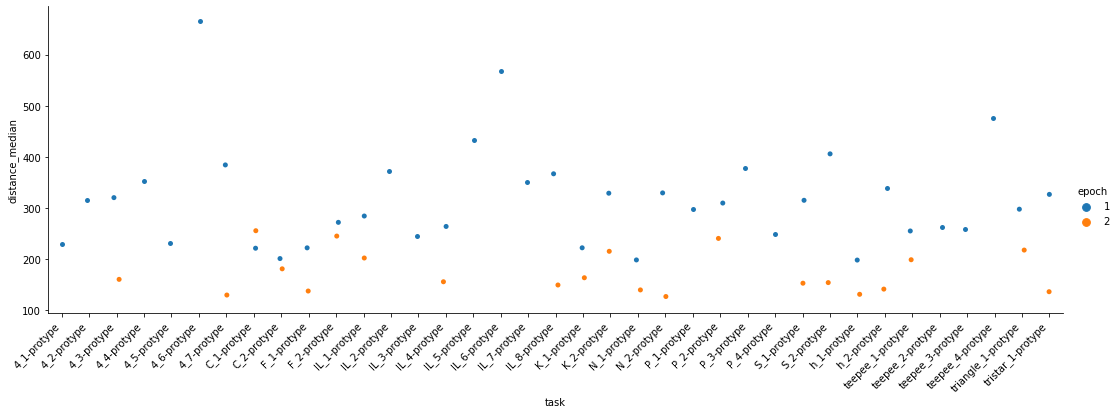

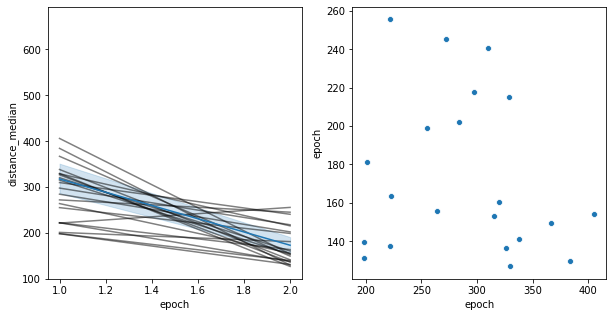

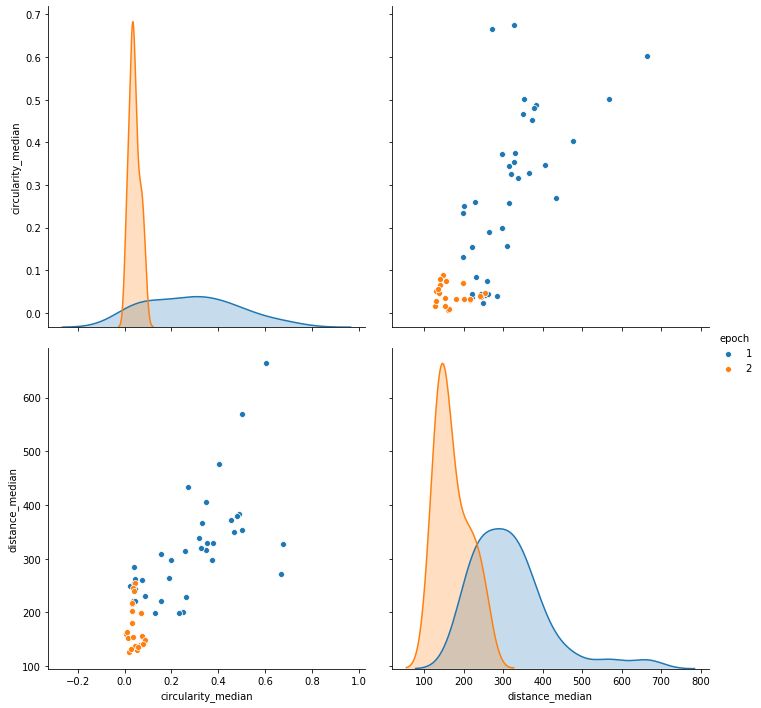

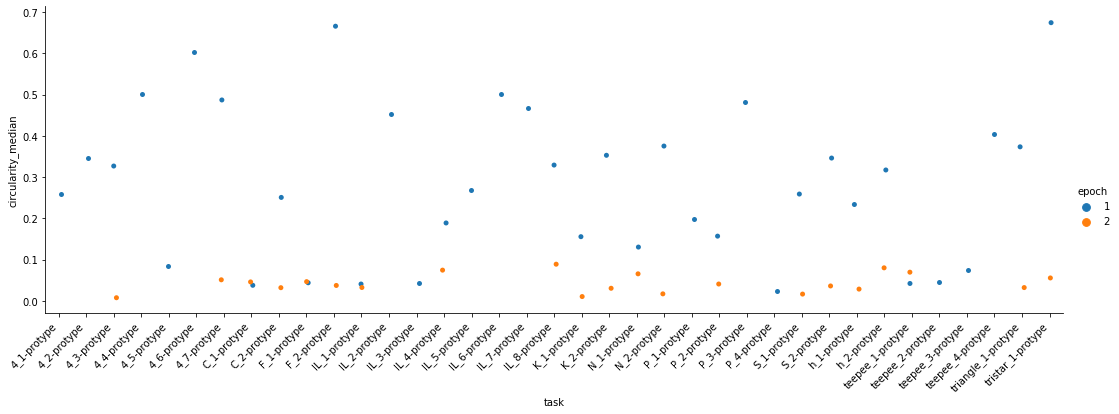

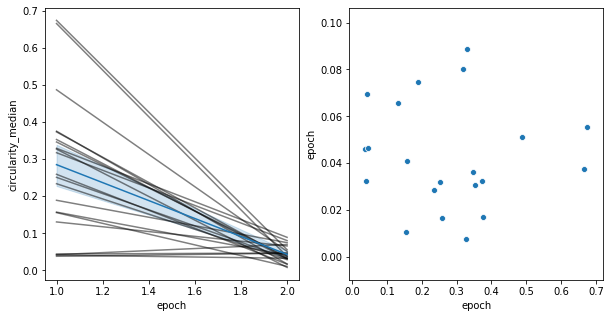

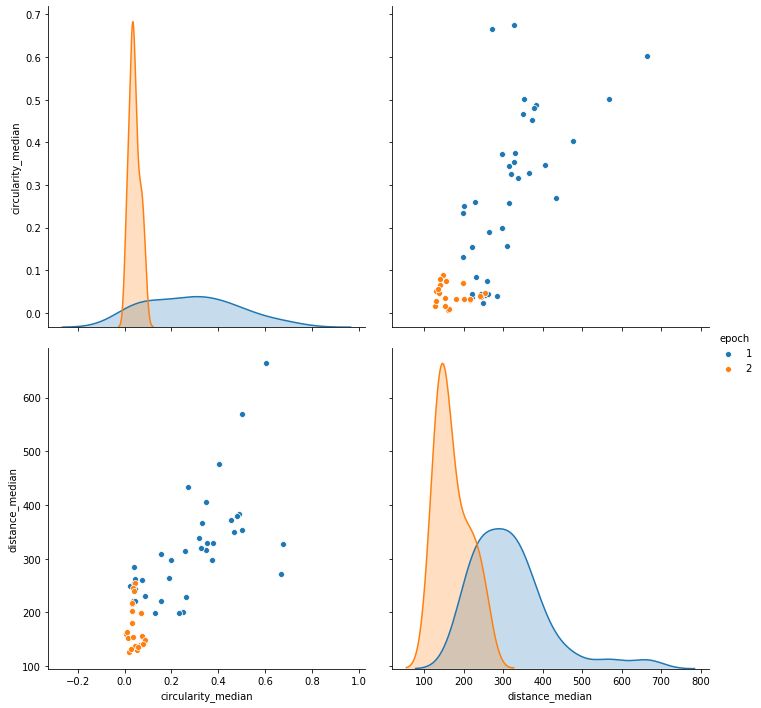

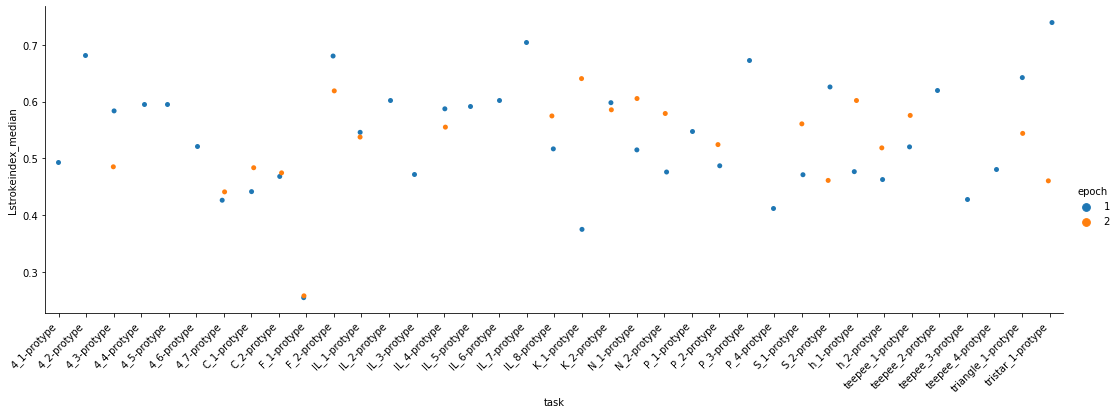

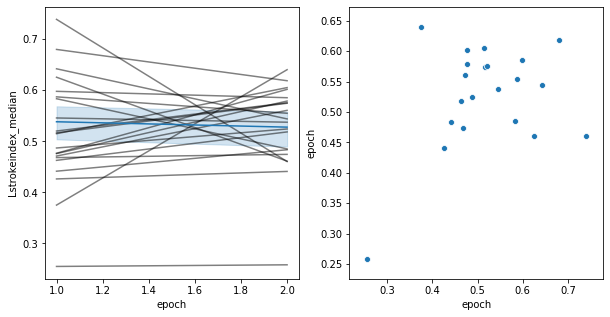

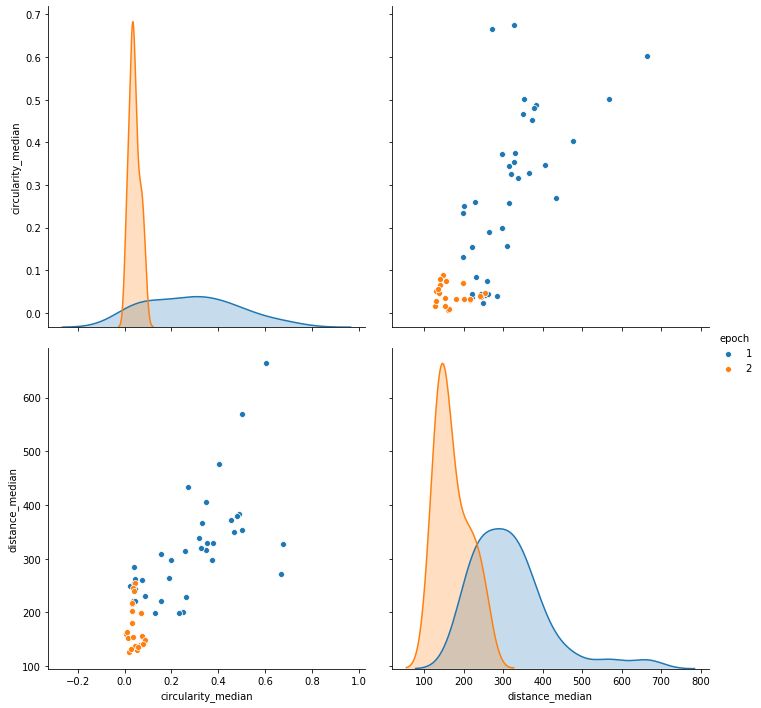

In [5]:
# 1) Load data across days
from pythonlib.tools.datetools import getDateList
from analysis.line2 import PROBEDATfromFD
import seaborn as sns
import pandas as pd
from analysis.line2 import probedat2strokefeats

sdate = 200902
edate = 200907
datelist = getDateList(sdate, edate)

expt = "lines2"

# === METADAT ABOUT EXPERIMENT
task_train_test = {
'probe1_liketrain':"train",
'probe1_nostrokeconstraint':"train",
'probe3':"test",
'probe3_hdpos':"test",
'train':"train"}
        
matchedstrokes = [0,1] # these strokes are aggregated on each day. expect these to be comaprable across days.

# ==== STROKES MOTOR MODEL PARAMS
strokmodel_kind='spatial'
strokmodel_tstamp = '200922_093340_lines2'

# for animal in ["Pancho", "Red"]:
for animal in ["Pancho"]:
    
    dattoget = []
    for d in datelist:
        dattoget.append([expt, animal, d])
        
    FD = loadMultData(dattoget)

    # saving dir
    SAVEDIR = f"{FD[0]['fd']['params']['figuredir_notebook']}/analysis_line2_090720/multday_{animal}_{sdate}_to_{edate}"
    import os
    os.makedirs(SAVEDIR, exist_ok=True)
    print(f"saving at {SAVEDIR}")

    # ==== Flatten all trials across days x animals
    # for each trial collect relevant information
    PROBEDAT = PROBEDATfromFD(FD)
    
    

    # ==== EXTRACT STROKE MODEL RESULTS
    modResGetter = modelResultsGetter(PROBEDAT, model=strokmodel_kind, 
                                      fit_tstamp = strokmodel_tstamp)

    for traintest in ["train", "test", "bothtraintest"]:
#     for traintest in ["test"]:
        for only_first_last_trials in [False, True]:
    #         = True # then gets last trial of epoch 1 and first trial of epoch 2

            if only_first_last_trials:
                # then should get all trials to make sure not miss any
                from pythonlib.tools.datetools import getDateList
                DATELIST = getDateList("200902", "200907")

                datecategories = {
                    "200902":1, 
                    "200903":1,
                    "200904":2,
                    "200905":2,
                    "200906":2,
                    "200907":2}
            else:
                DATELIST = ["200902", "200903", "200906", "200907"]
                datecategories = {
                    "200902":1, 
                    "200903":1,
                    "200906":2,
                    "200907":2}

            only_shared_tasks = False # not needed, since will filter below to make sure in both epochs.
            strokfeats, TASKLIST = probedat2strokefeats(PROBEDAT, DATELIST, only_shared_tasks=only_shared_tasks)

            # ==== add model results to strokfeats
            if False:
                ## assign model results to each individual stroke
                # [SCRATCH HERE]
                for s in strokfeats:

                    s["mod_res"] = modResGetter(animal, date=s["date"], expt=expt, session=s["session"], trial=s["trial"], 
                                                strok_num=s["strokenum"])


                SF = pd.DataFrame(strokfeats)
                SF = pd.DataFrame([s for s in strokfeats if s["mod_res"] is None])
                sns.catplot(x="date", y="distance", data=SF, height=20)

                SF = pd.DataFrame([s for s in strokfeats if s["mod_res"] is not None])
                sns.catplot(x="date", y="distance", data=SF, height=20)

            
            #### move all below into plotting function
            # === ADD MODEL RESULTS
            k = "Lstrokeindex"
            if k=="Lstrokeindex":
                kactual = "0/(0+1)"
            for s in strokfeats:
                mod_res = modResGetter(animal, date=s["date"], expt=expt, session=s["session"], trial=s["trial"], 
                                            strok_num=s["strokenum"])
                if mod_res is not None:
                    s[k] = mod_res[kactual].values[0]
                else:
                    s[k] = np.nan


            ## CONVERT TO DATAFRAME FOR PLOTTING
            SF = pd.DataFrame(strokfeats)

            ## APPEND columns refelcting experimental structure
            from pythonlib.tools.pandastools import applyFunctionToAllRows

            # --- aggregate over strokes of a desired index
            F = lambda x:x["strokenum"] in matchedstrokes
            SF = applyFunctionToAllRows(SF, F, newcolname="keepstroke")

            # --- aggregate over strokes of a desired index
            F = lambda x:datecategories[x["date"]]
            SF = applyFunctionToAllRows(SF, F, newcolname="epoch")

            # --- call each task either test or train
            F = lambda x:task_train_test[x["task_kind"]]
            SF = applyFunctionToAllRows(SF, F, newcolname="traintest")


            if traintest in ["train", "test"]:
                SF = SF[SF["traintest"]==traintest]
            elif traintest=="bothtraintest":
                SF = SF

            # - only keep tasks that have at least one datapoint in epoch1 and 2
            epochs_to_check = list(set([d for d in datecategories.values()]))
            def F(x, epochs_to_check = epochs_to_check):
                """ True if has data for all epochs"""
                checks  = []
                for ep in epochs_to_check:
                    checks.append(ep in x["epoch"].values)
                return all(checks)
            SF = SF.groupby(["task"]).filter(F)

            # == only keep if includes model results
            SF = SF[~np.isnan(SF[k])]




            #  ==== ONLY INCLUDE LAST (OF FIRST EPOCH) AND FIRST (OF LAST EPOCH) TRIALS
            if only_first_last_trials:
                # -- get last trial for first epoch
                tmp = SF[SF["epoch"]==1]
                tmp = tmp[tmp.groupby(["task", "epoch"])["datetime"].transform(max) == tmp["datetime"]]


                # -- get first trial of last epoch
                tmp2 = SF[SF["epoch"]==2]
                tmp2= tmp2[tmp2.groupby(["task", "epoch"])["datetime"].transform(min) == tmp2["datetime"]]


                # -- combine in a new dataframe
                SF = pd.concat([tmp, tmp2])

            # === MAKE SAVE DIRECTORY
            if only_first_last_trials:
                SAVEDIRTHIS = f"{SAVEDIR}/strokefeatures_firstlasttrials_{traintest}"
                import os 
                os.makedirs(SAVEDIRTHIS, exist_ok=True)
            else:
                SAVEDIRTHIS = f"{SAVEDIR}/strokefeatures_alltrials_{traintest}"
                import os 
                os.makedirs(SAVEDIRTHIS, exist_ok=True)    


            # --- plot date for each task
            #             from pythonlib.tools.snstools import rotateLabel
            fig = plt.figure(figsize=(15,10))
            ax = sns.scatterplot(data=SF, x="date", y="task", hue="epoch")
            if only_first_last_trials:
                plt.title("last trial (first epoch) and first trial (last epoch)")                  
            else:
                plt.title("all trials")
            # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            fig.savefig(f"{SAVEDIRTHIS}/overview_timeline.pdf")

            # reget new tasklist
            TASKLIST = sorted(set(SF["task"].values))

            # =========== PLOT - one plot per task
            for task in TASKLIST:
                SFthis = SF.loc[SF["task"]==task]
            #     SF = pd.DataFrame([s for s in strokfeats if s["task"]==task])

                # -- PLOT
                fig = sns.pairplot(SFthis, vars = ["strokenum", "circularity", "distance", k, "epoch"], hue="date")
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-1.pdf")
                fig = sns.pairplot(SFthis, vars = ["strokenum", "circularity", k, "distance"], hue="epoch")
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-2.pdf")
                fig = sns.catplot(data=SFthis, x="epoch", y="distance", col="strokenum", hue="date", jitter=True, aspect=0.5)
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-3.pdf")
                fig = sns.catplot(data=SFthis, x="epoch", y="circularity", col="strokenum", hue="date", jitter=True, aspect=0.5)
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-4.pdf")
                fig = sns.catplot(data=SFthis, x="epoch", y=k, col="strokenum", hue="date", jitter=True, aspect=0.5)
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-5.pdf")

                # -- PLOT, aggregating over first N strokes.
                SF2 = SFthis.loc[SFthis["keepstroke"]==True]
                fig = sns.pairplot(SF2, vars = ["circularity", "distance", k, "epoch"], hue="date")
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-aggregNstrokes-1.pdf")
                fig = sns.pairplot(SF2, vars = ["circularity", "distance",  k], hue="epoch")
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-aggregNstrokes-2.pdf")
                fig = sns.catplot(data=SF2, x="epoch", y="distance", hue="date", jitter=True, aspect=0.5)
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-aggregNstrokes-3.pdf")
                fig = sns.catplot(data=SF2, x="epoch", y="circularity", hue="date", jitter=True, aspect=0.5)
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-aggregNstrokes-4.pdf")
                fig = sns.catplot(data=SF2, x="epoch", y=k, hue="date", jitter=True, aspect=0.5)
                fig.savefig(f"{SAVEDIRTHIS}/pairplot_{task}-aggregNstrokes-5.pdf")

                plt.close("all")


            ## ==== Summary across tasks
            # aggregate: for each task, get one value for epoch 1, one value for epoch 2
            # (aggreagte over stroke and days)

            # -- 1) Do aggregation
            from pythonlib.tools.pandastools import aggregGeneral
            group = ["task", "epoch"]
            values = ["circularity", "distance", k]
            SFagg = SF.loc[SF["keepstroke"]==True]
            SFagg = aggregGeneral(SFagg, group, values, aggmethod=["mean", "median"])

            # -- 2) Plot
            for y in ["distance_median", "circularity_median", f"{k}_median"]:
                from pythonlib.tools.snstools import rotateLabel

                fig = sns.catplot(x ="task", y=y, data=SFagg, hue="epoch", aspect=3)
                rotateLabel(fig)
                fig.savefig(f"{SAVEDIRTHIS}/summary_aggregStrokesDates-{y}-1.pdf")

            #     sns.catplot(data=SFagg, x="epoch", y=y)
            #     sns.catplot(data=SFagg, x="epoch", y=y, kind="point")
                fig = plt.figure(figsize=(10,5))

                plt.subplot(121)
                for task in set(SFagg["task"]):
                    sns.lineplot(data=SFagg.loc[SFagg["task"]==task], x="epoch", y=y, color="k", alpha=0.5)
                sns.lineplot(data=SFagg, x="epoch", y=y)

                plt.subplot(122)
                Y = SFagg.pivot(index="task", columns="epoch", values=y)
                Y = pd.DataFrame(Y.to_records())
            #         fig = plt.figure(figsize=(5,5))
                sns.scatterplot(data =Y, x="1", y="2")
                plt.xlabel("epoch")
                plt.ylabel("epoch")

                fig.savefig(f"{SAVEDIRTHIS}/summary_aggregStrokesDates-{y}-2.pdf")

                # --
                fig = sns.pairplot(SFagg, vars = ["circularity_median", "distance_median", f"{k}_median"], hue="epoch", height=5)
                fig.savefig(f"{SAVEDIRTHIS}/summary_aggregStrokesDates-{y}-3.pdf")

## plot metadat across days


In [ ]:

for animal in ["Pancho", "Red"]:
    
    dattoget = []
    for d in datelist:
        dattoget.append([expt, animal, d])
        
    FD = loadMultData(dattoget)

    # saving dir
    SAVEDIR = f"{FD[0]['fd']['params']['figuredir_notebook']}/analysis_line2_090720/multday_{animal}_{sdate}_to_{edate}"
    import os
    os.makedirs(SAVEDIR, exist_ok=True)
    print(f"saving at {SAVEDIR}")

    # ==== Flatten all trials across days x animals
    # for each trial collect relevant information
    PROBEDAT = PROBEDATfromFD(FD)

    # then should get all trials to make sure not miss any
    from pythonlib.tools.datetools import getDateList
    DATELIST = getDateList("200902", "200907")

    datecategories = {
        "200902":1, 
        "200903":1,
        "200904":2,
        "200905":2,
        "200906":2,
        "200907":2}

    only_shared_tasks = False # not needed, since will filter below to make sure in both epochs.

    task_train_test = {
    'probe1_liketrain':"train",
    'probe1_nostrokeconstraint':"train",
    'probe3':"test",
    'probe3_hdpos':"test",
    'train':"train"}

    matchedstrokes = [0,1] # these strokes are aggregated on each day. expect these to be comaprable across days.

    only_shared_tasks = False # not needed, since will filter below to make sure in both epochs.
    strokfeats, TASKLIST = probedat2strokefeats(PROBEDAT, DATELIST, only_shared_tasks=only_shared_tasks)

    ## CONVERT TO DATAFRAME FOR PLOTTING
    SF = pd.DataFrame(strokfeats)

    ## APPEND columns refelcting experimental structure
    from pythonlib.tools.pandastools import applyFunctionToAllRows

    # --- aggregate over strokes of a desired index
    F = lambda x:x["strokenum"] in matchedstrokes
    SF = applyFunctionToAllRows(SF, F, newcolname="keepstroke")

    # --- aggregate over strokes of a desired index
    F = lambda x:datecategories[x["date"]]
    SF = applyFunctionToAllRows(SF, F, newcolname="epoch")

    # --- call each task either test or train
    F = lambda x:task_train_test[x["task_kind"]]
    SF = applyFunctionToAllRows(SF, F, newcolname="traintest")



    fig1 = sns.catplot(x="date", y="task_category", hue="random_task", data=SF, aspect=3, row_order=sorted(set(SF["task_category"])))
    fig2 = sns.catplot(x="date", y="task_category", hue="random_task", row="traintest", data=SF, aspect=3)

    # for fixed tasks only
    # sns.catplot(x="date", y="task", hue="task_category", row="traintest", data=SF[SF["random_task"]==False], 
    #             height=10, aspect=1, row_order=sorted(set(SF["task"])))
    fig3 = sns.catplot(x="date", y="task", hue="task_category", row="traintest", data=SF[SF["random_task"]==False], 
                height=10, aspect=1)
    
    fig1.savefig(f"{SAVEDIR}/overview-1.pdf")
    fig2.savefig(f"{SAVEDIR}/overview-2.pdf")
    fig3.savefig(f"{SAVEDIR}/overview-3.pdf")
    


In [ ]:
# == 1) For each day, plot tasks sorted by category.

for date in DATELIST:
    print(f"======= {date}")
    traintaskcats = sorted(set([P["task_stagecategory"] for P in PROBEDAT if P["date"]==date]))
    for cat in traintaskcats:
        print(f"--- {cat}")
        for RANDOM in [True, False]:
            tasknames = sorted(set([P["unique_task_name"] for P in PROBEDAT
                              if P["date"]==date
                              and P["random_task"]==RANDOM
                                   and P["task_stagecategory"]==cat]))
            if len(tasknames)==0:
                continue
            if RANDOM:
                print("-RANDOM")
            else:
                print("-FIXED")
            if len(tasknames)>15:
                print(f"found {len(tasknames)} tasks, eg {tasknames[0]}")
            else:
                print(tasknames)
#         assert False
                          
    
    
    
    

 



## Plot all tasks (no behavior)


In [ ]:
# ************** PLOT ALL FIXED TASKS (collect across days)
for TRAINTEST in ["train", "test"]:

    # then plot all
    tasknames = sorted(set([P["unique_task_name"] for P in PROBEDAT
                      if P["random_task"]==False
                            and task_train_test[P["kind"]]==TRAINTEST]))

    # get one index per taskname
    fdlist = []
    triallist =[]
    titlelist = []
    for task in tasknames:
        fdlist.append([P["filedata"] for P in PROBEDAT
                        if P["unique_task_name"]==task][0])
        triallist.append([P["trial"] for P in PROBEDAT
                        if P["unique_task_name"]==task][0])
        titlelist.append(task)
    print(titlelist)

    fig = plotMultTrialsSimple(fdlist, trials_list=triallist, rand_subset=None, 
                               empty_title=False, zoom=True, plot_fix=True, alpha=1, titles=titlelist,
                        plotargs={"plot_task_stimulus":True, 
                                "plot_drawing_behavior":False, "nakedplot":True,
                               })
    fig.savefig(f"{SAVEDIR}/alltasks_fixed_alldays_{TRAINTEST}.pdf")

    
    
# *** FOR EACH DAY, PLOT SUBSET OF RANDOM TASKS.
TRAINTEST = "train"
for date in DATELIST:
    print(f"======= {date}")
    traintaskcats = sorted(set([P["task_stagecategory"] for P in PROBEDAT 
                                if P["date"]==date
                               and P["random_task"]==True
                               and task_train_test[P["kind"]]==TRAINTEST]))
    for cat in traintaskcats:
        print(f"--- {cat}")
        
        # then just plot example tasks
        fdlist = [P["filedata"] for P in PROBEDAT
                          if P["date"]==date
                          and P["random_task"]==True
                        and P["task_stagecategory"]==cat
                 and task_train_test[P["kind"]]==TRAINTEST]
        triallist = [P["trial"] for P in PROBEDAT
                          if P["date"]==date
                          and P["random_task"]==True
                        and P["task_stagecategory"]==cat
                 and task_train_test[P["kind"]]==TRAINTEST]
        titlelist = [P["unique_task_name"] for P in PROBEDAT
                          if P["date"]==date
                          and P["random_task"]==True
                        and P["task_stagecategory"]==cat
                 and task_train_test[P["kind"]]==TRAINTEST]

        Nrand = 60
        fig = plotMultTrialsSimple(fdlist, trials_list=triallist, rand_subset=Nrand, 
                                   empty_title=False, zoom=True, plot_fix=True, alpha=1, titles=titlelist,
                            plotargs={"plot_task_stimulus":True, 
                                    "plot_drawing_behavior":False, "nakedplot":True,
                                   })
        fig.savefig(f"{SAVEDIR}/alltasks-random-{date}-{cat}-{TRAINTEST}.pdf")
        plt.close()


# CATEGORIZE STROKES

In [ ]:
# ******* LOAD PANCHO FOR CODE DEVO
for animal in ["Pancho"]:
    
    dattoget = []
    for d in datelist:
        dattoget.append([expt, animal, d])
        
    FD = loadMultData(dattoget)

    # saving dir
    SAVEDIR = f"{FD[0]['fd']['params']['figuredir_notebook']}/analysis_line2_090720/multday_{animal}_{sdate}_to_{edate}"
    import os
    os.makedirs(SAVEDIR, exist_ok=True)
    print(f"saving at {SAVEDIR}")

    # ==== Flatten all trials across days x animals
    # for each trial collect relevant information
    PROBEDAT = PROBEDATfromFD(FD)

    # then should get all trials to make sure not miss any
    from pythonlib.tools.datetools import getDateList
    DATELIST = getDateList("200902", "200907")

    datecategories = {
        "200902":1, 
        "200903":1,
        "200904":2,
        "200905":2,
        "200906":2,
        "200907":2}

    only_shared_tasks = False # not needed, since will filter below to make sure in both epochs.

    task_train_test = {
    'probe1_liketrain':"train",
    'probe1_nostrokeconstraint':"train",
    'probe3':"test",
    'probe3_hdpos':"test",
    'train':"train"}

    matchedstrokes = [0,1] # these strokes are aggregated on each day. expect these to be comaprable across days.

    only_shared_tasks = False # not needed, since will filter below to make sure in both epochs.
    strokfeats, TASKLIST = probedat2strokefeats(PROBEDAT, DATELIST, only_shared_tasks=only_shared_tasks)

    ## CONVERT TO DATAFRAME FOR PLOTTING
    SF = pd.DataFrame(strokfeats)

    ## APPEND columns refelcting experimental structure
    from pythonlib.tools.pandastools import applyFunctionToAllRows

    # --- aggregate over strokes of a desired index
    F = lambda x:x["strokenum"] in matchedstrokes
    SF = applyFunctionToAllRows(SF, F, newcolname="keepstroke")

    # --- aggregate over strokes of a desired index
    F = lambda x:datecategories[x["date"]]
    SF = applyFunctionToAllRows(SF, F, newcolname="epoch")

    # --- call each task either test or train
    F = lambda x:task_train_test[x["task_kind"]]
    SF = applyFunctionToAllRows(SF, F, newcolname="traintest")


In [ ]:
# ******** 1) Plot grid of all strokes to visualize if any structure


In [ ]:
# ***** 2) Do stuff with the timecourse?

i = random.randint(0, len(PROBEDAT))

In [ ]:
plotTrialSingleOverview(PROBEDAT[i]["filedata"], PROBEDAT[i]["trial"]);
# plotTrialSimpleTimecourse(PROBEDAT[i]["filedata"], PROBEDAT[i]["trial"])
# plotTrialSimple(PROBEDAT[i]["filedata"], PROBEDAT[i]["trial"], zoom=True, plotver="order", kwargs={'each_stroke_separate': True})

### FIT GENERATIVE MODEL FOR SINGLE STROKES
### See other notebook for model-only


## === SCRATCH

In [ ]:
## FOR EACH TASK, PLOT THE DISTRIBUTIONS OF FEATURES, COMPARING TWO DAYS

DATE1 = "200903"
DATE2 = "200907"
TASKlIST = "F_1-protype"

# --- get flattened list of all stroks
DAT = []
for P in PROBEDAT:
    if P["date"] in [DATE1, DATE2] and P["unique_task_name"]==TASK:
        DAT.append(
            {
                "date":str(P["date"]),
                "strokes":getTrialsStrokesByPeanuts(P["filedata"], P["trial"])
            })

##############################
strokesfeatures = strokeFeatures([D["strokes"] for D in DAT])
for sf, D in zip(strokesfeatures, DAT):
    D["features"] = sf
    
strokfeats = flattenByStrok(DAT)
strokfeats[0]


# --- Plot distributions
SF = pd.DataFrame(strokfeats)
sns.pairplot(SF, vars = ["strokenum", "circularity", "distance"], hue="date", kind="reg")
sns.pairplot(SF, vars = ["strokenum", "circularity", "distance"], hue="date")

sns.catplot(data=SF, x="date", y="distance", hue="strokenum", jitter=True)

In [ ]:
def strokefeats2title(strokfeats):
    """strokfeats is a list of dicts.
    title is string, each row is a list element"""
    sfeat = strokfeats[0]
    s = ""
    for i, sfeat in enumerate(strokfeats):
        s=f"{s}\n[{i+1}]"
        for k, v in sfeat.items():
            if k!="strokenum":
                s=f"{s}-{k[:3]}"
                s=f"{s}({v:.2f})"
        #     s+=v
    return s
#     print(s)

In [ ]:
# === PLOT TRAILS STROKES ALONG WITH THEIR FEATURES

idxlist = [random.randrange(1, len(PROBEDAT)) for _ in range(20)]

# 1) collect features
# strokeslist = [getTrialsStrokesByPeanuts(PROBEDAT[i]["filedata"], PROBEDAT[i]["trial"]) for i in idxlist]
# strokfeats = strokeFeatures(strokeslist)

# 2) plot
titles = []
filedatas = []
trialslist = []
for i in idxlist:
    strokeslist = [getTrialsStrokesByPeanuts(PROBEDAT[i]["filedata"],PROBEDAT[i]["trial"])]
    strokfeats = strokeFeatures(strokeslist)[0]
    
    titles.append(strokefeats2title(strokfeats))
    filedatas.append(PROBEDAT[i]["filedata"])
    trialslist.append(PROBEDAT[i]["trial"])
    
plotMultTrialsSimple(filedatas, trialslist, titles=titles, zoom=True, strokes_ver="peanuts");
    
    
    

In [ ]:
strokeFeatures(strokeslist)

In [ ]:

# compute distribution of angle bends per stroke




In [ ]:
plt.figure()



    2a) Cluster strokes:
    a) using statistics above
    b) pairwise distance matrix;
    show that there are lines and Ls as two distinct clusters.


    2) Categories strokes
    - for each stroke, categorize based on the clustering model above.
    [ Or do it in a supervised way?]
    -- goal: 2d plot (line weight vs. L-weight, probabilistic).

    3) Model-based analysis - assigning entire parse a score.

## BELOW - OLD SCRATCH

In [ ]:
# === LOAD ALL SESSIONS FOR A DAY
# A = [("lines1", "Red", 200831),
#  ("lines1", "Pancho", 200831),
#  ("ESC1", "Red", 200830),
#  ("ESC1", "Pancho", 200830)]
A = [("lines2", "Red", 200907),
 ("lines2", "Pancho", 200907)]

for (expt, animal, date) in A:

    # expt = "lines1"
    # animal = "Red"
    # date = 200831

    # expt = "ESC1"
    # animal = "Red"
    # date = 200830

    # simple, just try many sessions...
    fdsessions = []
    FD = {}
    N = 12
    for session in range(10):
        fd = loadSingleData(animal, date, expt, session, resave_as_dict=False, load_resaved_data=True, 
                          resave_overwrite=False)
        if fd is not None:
            print(f"appending fd for sess {session}")
            fdsessions.append({
                "session": session,
                "fd":fd})
            FD[session] = fd
            if session==N-1:
                assert False, "got the end and still found.. you need to search for even more sessions..."

            SAVEDIR = f"{fd['params']['figuredir_notebook']}/probes/{animal}_{date}"
            import os
            os.makedirs(SAVEDIR, exist_ok=True)


    print("--- SUMMARY")
    for f in fdsessions:
        print(f"session: {f['session']}, ntrials: {f['fd']['params']['n_trials']}")


    # === categorize all trials based on task/probe, etc
    probedat = []
    ct = 0
    for sess, fd in FD.items():
        for t in getIndsTrials(fd):
            if getTrialsFixationSuccess(fd, t):
                probe = getTrialsTaskProbeInfo(fd, t)
                task = getTrialsTask(fd, t)
                
#                 print(probe)
                
                if probe["prototype"]==0 and len(probe["saved_setnum"])==0 and probe["resynthesized"]==0:
                    # then this is new random task sampled each block.
                    randomtask = True
                else:
                    randomtask = False

                if probe["probe"]==0:
                    kind = "train"
                else:
                    if probe["feedback_ver"]=="same_as_task" and randomtask==False:
                        if probe["constraints_to_skip"]=={}:
                            kind = "probe1_liketrain"
                        elif "strokes" in probe["constraints_to_skip"].values():
                            kind = "probe1_nostrokeconstraint"
                    elif probe["feedback_ver"]=="same_as_task" and randomtask==True and probe["constraints_to_skip"]=={}:
                        kind = "probe2_liketrain"
                    elif probe["feedback_ver"]=="same_as_task" and randomtask==True and "strokes" in probe["constraints_to_skip"].values():
                        kind = "probe2_nostrokeconstraint"
                    elif probe["feedback_ver"] in ["thresh_active", "mid_reward"] and randomtask==False and "strokes" in probe["constraints_to_skip"].values():
                        kind = "probe3"
                    elif probe["feedback_ver"] in ["same_except_model"] and randomtask==False and "strokes" in probe["constraints_to_skip"].values():
                        kind = "probe3_hdpos"
                    elif probe["feedback_ver"] in ["thresh_active", "mid_reward"] and randomtask==True and "strokes" in probe["constraints_to_skip"].values():
                        kind = "probe4"
                    else:
                        print(probe)
                        assert False, "what kind is this?"

                probedat.append({
                    "session":sess,
                    "trial":t,
                    "trial_day":ct,
                    "kind":kind,
                    "taskname": probe["unique_name"],
                    "stage":task["stage"],
                    "block":getTrialsBlock(FD[sess], t),
                    "prototype":probe["prototype"],
                    "constraints_to_skip":probe["constraints_to_skip"]})
                ct+=1


    # == for each category, list names of all tasks
    kindlist = set([p["kind"] for p in probedat])
    print("probe kinds -- trials");
    for kind in kindlist:
        print(" ")
        print(kind)
        trials = [p["trial"] for p in probedat if p["kind"]==kind]
        tasknames = [p["taskname"] for p in probedat if p["kind"]==kind]
    #     print(trials)
        print(set(tasknames))
        plt.figure()
        plt.plot(trials, tasknames)

    import seaborn as sns
    import pandas as pd
    dframe = pd.DataFrame(probedat)

    # sns.scatterplot(x="trial", y="taskname", data=dframe, hue="kind")
    fig, axes = plt.subplots(5, 1, sharex=True, squeeze=False, figsize=(28, 10))

    sns.scatterplot(x="trial_day", y="kind", data=dframe, hue="kind", ax=axes[0][0])
    sns.scatterplot(x="trial_day", y="stage", data=dframe, hue="kind", ax=axes[1][0])
    sns.scatterplot(x="trial_day", y="stage", data=dframe, hue="prototype", ax=axes[2][0])
    sns.lineplot(x="trial_day", y="session", data=dframe, ax=axes[3][0])
    sns.lineplot(x="trial_day", y="block", data=dframe, ax=axes[4][0])

    fig.savefig(f"{SAVEDIR}/overviewAllTrials.pdf")



    stagelist = set([p["stage"] for p in probedat])
    sesslist = set([p["session"] for p in probedat])    
    kindlist = set([p["kind"] for p in probedat])

    ## PLOT PROBE TASKS OVER THE ENTIRE DAY
    maxtrialsplot = 80

    for kind in kindlist:
        for stage in stagelist:
            for s in sesslist:
                trialsthis = [p["trial"] for p in probedat if p["session"]==s and p["kind"]==kind and p["stage"]==stage]
                fd = FD[s]
                print(f"-- for session {s}, kind {kind}, stage {stage}; trials:")
                print(trialsthis)

                if len(trialsthis)>0:
                    if len(trialsthis)>maxtrialsplot:
                        trialsthis = sorted(random.sample(trialsthis, maxtrialsplot))                        
                        r = None
                    else:
                        r = None
                    titles = []
                    for t in trialsthis:
                        mscore = getTrialsBehEvaluation(fd, t)["output"]["modelscore"]["value"][0][0]
                        bscore = getTrialsBehEvaluation(fd, t)["beh_multiplier"][0][0]                                               
                        titles.append(f"{t},bk{getTrialsBlock(fd, t)},{getTrialsTask(fd, t)['str']}\nmsco{mscore:.2f},bsco{bscore:.2f}")

#                         titles = [f"{t},bk{getTrialsBlock(fd, t)}{getTrialsTask(fd, t)['str']}\nmscore{mscore}" for t in trialsthis]
                    # plot
                    
                    # construct titles
                    
                    fig1 = plotMultTrialsSimple(fd, trialsthis, zoom=True, strokes_ver="peanuts", plot_fix=True,
                                            plotver="strokes", rand_subset = r, titles=titles)

                    scores = [getTrialsScoreRecomputed(fd, t, normalize=True) for t in trialsthis]
                    scores_compos = [getTrialsScoreRecomputed(fd, t, ver="DTW_min", normalize=True) for t in trialsthis]
                    scores_compos2 = [getTrialsScoreRecomputed(fd, t, ver="DTW_min_minus_max", normalize=True) for t in trialsthis]

                    # == plot quick scores
                    fig2 = plt.figure(figsize=(10, 12))

                    plt.subplot(311)
                    plt.title(f"session {s}, kind {kind}, stage {stage}")
                    plt.plot(trialsthis, scores, "ok", label="pts")
    #                 plt.plot(trialsthis, scores_compos, "or", label="compositonal")
    #                 plt.plot(trialsthis, scores_compos2, "og", label="compositonal_min_minus_max")
                    plt.ylabel("score (pts) (norm HD, high is good)")
                    plt.ylim([-0.2, 1])
                    plt.legend()

                    plt.subplot(312)
                    plt.title(f"session {s}, kind {kind}, stage {stage}")
    #                 plt.plot(trialsthis, scores, "ok", label="pts")
                    plt.plot(trialsthis, scores_compos, "or", label="compositonal")
    #                 plt.plot(trialsthis, scores_compos2, "og", label="compositonal_min_minus_max")
                    plt.ylabel("score (compositonal) (norm HD, high is good)")
                    plt.ylim([-0.5, 1])
                    plt.legend()

                    plt.subplot(313)
                    plt.title(f"session {s}, kind {kind}, stage {stage}")
    #                 plt.plot(trialsthis, scores, "ok", label="pts")
    #                 plt.plot(trialsthis, scores_compos, "or", label="compositonal")
                    plt.plot(trialsthis, scores_compos2, "og", label="compositonal_min_minus_max")
                    plt.ylabel("score (compositonal_min_minus_max) (norm HD, high is good)")
                    #     plt.ylim([-0.2, 1])
                    plt.legend()

    #                 plt.subplot(212)
    #                 s1 = (scores - np.mean(scores))/np.std(scores)
    #                 s2 = (scores_compos - np.mean(scores_compos))/np.std(scores_compos)
    #                 s3 = (scores_compos2 - np.mean(scores_compos2))/np.std(scores_compos2)
    #                 plt.plot(trialsthis, s1, "ok", label="pts")
    #                 plt.plot(trialsthis, s2, "or", label="compositonal")
    #                 plt.plot(trialsthis, s3, "og", label="compositonal_min_minus_max")
    #                 plt.title("z-scored")
    #                 plt.ylabel("score (recomputed) (norm HD, high is good)")
    #                 plt.ylim([-3, 3])
    #                 plt.legend()

                    # save
                    fig1.savefig(f"{SAVEDIR}/trialsByProbeKind_{kind}-{stage}-sess{s}-fig1.pdf")
                    fig2.savefig(f"{SAVEDIR}/trialsByProbeKind_{kind}-{stage}-sess{s}-fig2.pdf")
    #                 fig2.savefig(f"{SAVEDIR}/trialsByProbeKind_sess{s}-{kind}-{stage}-fig2.pdf")





In [ ]:
getTrialsTask(fd, t)["savedTaskSet"]

In [ ]:
expt = "lines2"
animal = "Pancho"
date = 200904

fdsessions = []
FD = {}
N = 12
for session in range(10):
    fd = loadSingleData(animal, date, expt, session, resave_as_dict=False, load_resaved_data=True, 
                      resave_overwrite=False)
    if fd is not None:
        print(f"appending fd for sess {session}")
        fdsessions.append({
            "session": session,
            "fd":fd})
        FD[session] = fd
        if session==N-1:
            assert False, "got the end and still found.. you need to search for even more sessions..."

        SAVEDIR = f"{fd['params']['figuredir_notebook']}/probes/{animal}_{date}"
        import os
        os.makedirs(SAVEDIR, exist_ok=True)


print("--- SUMMARY")
for f in fdsessions:
    print(f"session: {f['session']}, ntrials: {f['fd']['params']['n_trials']}")


# === categorize all trials based on task/probe, etc
probedat = []
ct = 0
for sess, fd in FD.items():
    for t in getIndsTrials(fd):
        if getTrialsFixationSuccess(fd, t):
            probe = getTrialsTaskProbeInfo(fd, t)
            task = getTrialsTask(fd, t)

            if probe["probe"]==0:
                kind = "train"
            else:
                if probe["feedback_ver"]=="same_as_task" and probe["prototype"]==1:
                    if probe["constraints_to_skip"]=={}:
                        kind = "probe1_liketrain"
                    elif "strokes" in probe["constraints_to_skip"].values():
                        kind = "probe1_nostrokeconstraint"
                elif probe["feedback_ver"]=="same_as_task" and probe["prototype"]==0 and probe["constraints_to_skip"]=={}:
                    kind = "probe2_liketrain"
                elif probe["feedback_ver"]=="same_as_task" and probe["prototype"]==0 and "strokes" in probe["constraints_to_skip"].values():
                    kind = "probe2_nostrokeconstraint"
                elif probe["feedback_ver"] in ["thresh_active", "mid_reward"] and probe["prototype"]==1 and "strokes" in probe["constraints_to_skip"].values():
                    kind = "probe3"
                elif probe["feedback_ver"] in ["same_except_model"] and probe["prototype"]==1 and "strokes" in probe["constraints_to_skip"].values():
                    kind = "probe3_hdpos"
                elif probe["feedback_ver"] in ["thresh_active", "mid_reward"] and probe["prototype"]==0 and "strokes" in probe["constraints_to_skip"].values():
                    kind = "probe4"
                else:
                    print(probe)
                    assert False, "what kind is this?"

            probedat.append({
                "session":sess,
                "trial":t,
                "trial_day":ct,
                "kind":kind,
                "taskname": probe["unique_name"],
                "stage":task["stage"],
                "prototype":probe["prototype"],
                "constraints_to_skip":probe["constraints_to_skip"]})
            ct+=1

In [ ]:

## for each trial also get online and offline score
for p in probedat:
    s = p["session"]
    t = p["trial"]
    
    p["bk"] = getTrialsBlock(FD[s], t)
    p["bq"] = getTrialsBloque(FD[s], t)
    
    # score
    if getTrialsFixationSuccess(FD[s], t):
        p["score_model"] = getTrialsOutcomesWrapper(FD[s], t)["beh_evaluation"]["output"]["modelscore"]["value"][0][0]
        p["score_hd"] = getTrialsOutcomesWrapper(FD[s], t)["beh_evaluation"]["output"]["hausdorff"]["value"][0][0]
        p["score_offline"] = getTrialsScoreRecomputed(FD[s], t)
    
    
    
    

import pandas as pd

dfthis = pd.DataFrame(probedat)
dfthis

In [ ]:
### import seaborn as sns

y = "score_model"
sns.relplot(x = "trial", y=y, hue="bk", data=dfthis, row="kind", kind="scatter", aspect=3)
sns.relplot(x = "trial_day", y=y, hue="bk", data=dfthis, row="kind", kind="scatter", aspect=3)
sns.relplot(x = "bq", y=y, hue="bk", data=dfthis, row="kind", kind="scatter", aspect=3)

In [ ]:
### import seaborn as sns

y = "score_model"
sns.catplot(x = "bk", y=y, data=dfthis, row="kind", kind="point", aspect=3)
# sns.catplot(x = "bq", y=y, data=dfthis, col="kind", row="bk", kind="point", aspect=3)
sns.catplot(x = "bq", y=y, data=dfthis, row="kind", hue="bk", kind="point", aspect=3)

In [ ]:
## COMPUTE COMPOSITIONAL SCORE
# [Quick version] DTW score relative to non-DTW score

## ==== [testing] stroke based hd
from pythonlib.tools.stroketools import distanceDTW
t = random.sample(getIndsTrials(fd),1)[0]

strokes_beh = getTrialsStrokesByPeanuts(fd, t, replaynum=1)
strokes_task = getTrialsTaskAsStrokes(fd, t)

for ass in [True, False]:
    print(f"assymetric: {ass}")
    plotTrialSimple(fd, t, zoom=True, plot_fix=False, plotver="strokes", 
                    use_peanut_params={'replaynum': 1, 'active': True})

    print(distanceDTW(strokes_beh, strokes_task[::-1], ver="segments", asymmetric=ass))
    print(distanceDTW(strokes_beh, strokes_task, ver="segments", asymmetric=ass))

    plt.figure(figsize=(10,10))
    ax = plt.subplot(211)
    plotDatStrokes(strokes_beh, ax=ax)
    plotDatStrokes(strokes_task[::-1], ax=ax)

    ax = plt.subplot(212)
    plotDatStrokes(strokes_beh, ax=ax)
    plotDatStrokes(strokes_task, ax=ax)

# compute minimum score for all permutations of task strokes
# make assymetric false, so forced to use all task strokes.
print("-- all permutations")
from itertools import permutations
scores =[]
for s in permutations(strokes_task):
    print(distanceDTW(strokes_beh, s, ver="segments", asymmetric=False))
    scores.append(distanceDTW(strokes_beh, s, ver="segments", asymmetric=False)[0])
score = min(scores)
print(score)

In [ ]:
from pythonlib.tools.listtools import permuteRand

permuteRand([1,2,3], 6, not_enough_ok=True)
from itertools import permutations

for i in permutations([1,2,3]):
    print(i)


## SCRATCH

In [ ]:
featurestoplot = []
for key, val in getTrialsBlockParams(fd, 1)["behEval"]["beh_eval"].items():
    if val["feature"] =="hausdorff" and val["weight"][0][0]>0:
        featurestoplot.append("hausdorff")
    if val["feature"] =="frac_touched" and val["weight"][0][0]>0:
        featurestoplot.append("frac_touched")
featurestoplot.append("score_offline")

fig1, fig2 = plotOverview_(df, featurestoplot=featurestoplot)
fig1.savefig(f"{SAVEDIRDAY}/overview1.pdf")
fig2.savefig(f"{SAVEDIRDAY}/overview2.pdf")

# 2) relationship between reward and factors that go into reward
figs = plotReward(df, featurestoplot=featurestoplot)
for i, f in enumerate(figs):
    f.savefig(f"{SAVEDIRDAY}/reward_score_{i}.pdf")

# 3) PLOT BEHAVIOR FOR TRIALS SORTED BY SCORE
import copy
scoretypes = copy.copy(featurestoplot)
scoretypes.extend(["behscore", "reward"])
for score_type in scoretypes:
    FIGS = plotBehSortedByScore(df, fd, score_type)
    for ver, figs in FIGS.items():
        for i, f in enumerate(figs):
            f.savefig(f"{SAVEDIRDAY}/trialsSortedByScore_{score_type}_{ver}_{i}_.pdf")

# 4) Plot behavior subsampling in chronological order
trials = [t for t in getIndsTrials(fd) if getTrialsFixationSuccess(fd, t)]
Nrand = 80
fig = plotMultTrialsSimple(fd, trials, zoom=True, strokes_ver="peanuts", plot_fix=False,
                        plotver="strokes", rand_subset=Nrand)
fig.savefig(f"{SAVEDIRDAY}/trialsRandomChronOrder.pdf")

# 5) TASK VISUALIZATIONS, SCHEDULE, REPETITION
figs = plotTaskSchedules(df)
for i, f in enumerate(figs):
    f.savefig(f"{SAVEDIRDAY}/taskSchedule{i}.pdf")

In [ ]:
if False:
    animal = "Pancho"
    expt = "pilot"
    date = 200822
    session = 1

    fd = loadSingleData(animal, date, expt, session, resave_as_dict=False, load_resaved_data=True, 
                              resave_overwrite=False)

    ## ==== [testing] stroke based hd
    from pythonlib.tools.stroketools import distanceDTW
    t = random.sample(getIndsTrials(fd),1)[0]

    for ass in [True, False]:
        print(f"assymetric: {ass}")
        plotTrialSimple(fd, t, zoom=True, plot_fix=False, plotver="strokes", 
                        use_peanut_params={'replaynum': 1, 'active': True})

        strokes_beh = getTrialsStrokesByPeanuts(fd, t, replaynum=1)
        strokes_task = getTrialsTaskAsStrokes(fd, t)
        print(distanceDTW(strokes_beh, strokes_task[::-1], ver="segments", asymmetric=ass))
        print(distanceDTW(strokes_beh, strokes_task, ver="segments", asymmetric=ass))

        plt.figure(figsize=(10,10))
        ax = plt.subplot(211)
        plotDatStrokes(strokes_beh, ax=ax)
        plotDatStrokes(strokes_task[::-1], ax=ax)

        ax = plt.subplot(212)
        plotDatStrokes(strokes_beh, ax=ax)
        plotDatStrokes(strokes_task, ax=ax)


In [ ]:
## ==== plot scoring separated by task type

df = extractSessionDf(fd)

# === add note about what probe type this is



## TO DO:
(1) get all permutations
(2) normalize by num strokes.
(3) systematic - compare to old version.